In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

# Exploratory data analysis

In [2]:
# Load dataframes
train = pd.read_csv("data/train.csv", index_col = 0)
test = pd.read_csv("data/test.csv", index_col = 0)

# Get the ids to differentiate them after joining
train_ids = list(train.index)
test_ids = list(test.index)

# Join dataframes vertically
full = pd.concat([train, test], axis = 0)

## Data Leakage

In [3]:
# Let's save the features that aren't in both dataframes in a list
# To save the variables that are not in the test set
test_missing_features = []

for i in train.columns:
    if i not in test.columns:
        test_missing_features.append(i)

# To remove from the list the target variable "compliance" as I'll need it later
test_missing_features.pop()

test_missing_features

['payment_amount',
 'balance_due',
 'payment_date',
 'payment_status',
 'collection_status',
 'compliance_detail']

In [4]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311307 entries, 22056 to 369851
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   agency_name                 311307 non-null  object 
 1   inspector_name              311307 non-null  object 
 2   violator_name               311245 non-null  object 
 3   violation_street_number     311307 non-null  float64
 4   violation_street_name       311307 non-null  object 
 5   violation_zip_code          24024 non-null   object 
 6   mailing_address_str_number  306691 non-null  object 
 7   mailing_address_str_name    311300 non-null  object 
 8   city                        311306 non-null  object 
 9   state                       310883 non-null  object 
 10  zip_code                    311303 non-null  object 
 11  non_us_str_code             3 non-null       object 
 12  country                     311307 non-null  object 
 13  ticket_iss

In [5]:
# Drop variables that I don't have in the test set to avoid data leakage
full = full.drop(test_missing_features, axis = 1)

# Drop variables with too many missing values
too_many_missing = ["violation_zip_code", "non_us_str_code", "grafitti_status"]
full = full.drop(too_many_missing, axis = 1)

# Drop variables with irrelevant information
irrelevant_variables = ["violator_name", "violation_street_name", "mailing_address_str_name", "city", "zip_code", "violation_description", "violation_street_number", "mailing_address_str_number"]
full = full.drop(irrelevant_variables, axis = 1)

full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311307 entries, 22056 to 369851
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   agency_name         311307 non-null  object 
 1   inspector_name      311307 non-null  object 
 2   state               310883 non-null  object 
 3   country             311307 non-null  object 
 4   ticket_issued_date  311307 non-null  object 
 5   hearing_date        296619 non-null  object 
 6   violation_code      311307 non-null  object 
 7   disposition         311307 non-null  object 
 8   fine_amount         311306 non-null  float64
 9   admin_fee           311307 non-null  float64
 10  state_fee           311307 non-null  float64
 11  late_fee            311307 non-null  float64
 12  discount_amount     311307 non-null  float64
 13  clean_up_cost       311307 non-null  float64
 14  judgment_amount     311307 non-null  float64
 15  compliance          159880 non

## Datetime variables

In [6]:
# Transforming datetime variables to the corresponding format
full.ticket_issued_date = pd.to_datetime(full.ticket_issued_date)
full.hearing_date = pd.to_datetime(full.hearing_date)

# Datetime variables cannot be fed into the model just like that
# Let's do some preprocessing

#full["time_diff"] = full.hearing_date - full.ticket_issued_date
#full.loc[:, "time_diff"] = full["time_diff"].map(lambda x: pd.Timedelta(x) / np.timedelta64(1, "M"))
full["hearing_month"] = full.hearing_date.dt.month
full["ticket_issued_month"] = full.ticket_issued_date.dt.month

full.hearing_month = full.hearing_month.fillna(0)

full = full.drop(["hearing_date", "ticket_issued_date"], axis = 1)

In [7]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311307 entries, 22056 to 369851
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   agency_name          311307 non-null  object 
 1   inspector_name       311307 non-null  object 
 2   state                310883 non-null  object 
 3   country              311307 non-null  object 
 4   violation_code       311307 non-null  object 
 5   disposition          311307 non-null  object 
 6   fine_amount          311306 non-null  float64
 7   admin_fee            311307 non-null  float64
 8   state_fee            311307 non-null  float64
 9   late_fee             311307 non-null  float64
 10  discount_amount      311307 non-null  float64
 11  clean_up_cost        311307 non-null  float64
 12  judgment_amount      311307 non-null  float64
 13  compliance           159880 non-null  float64
 14  hearing_month        311307 non-null  float64
 15  ticket_issued

## Missing values

In [8]:
full.fine_amount.describe()

count    311306.000000
mean        354.493315
std         655.106290
min           0.000000
25%         100.000000
50%         250.000000
75%         250.000000
max       10000.000000
Name: fine_amount, dtype: float64

<AxesSubplot:xlabel='fine_amount'>

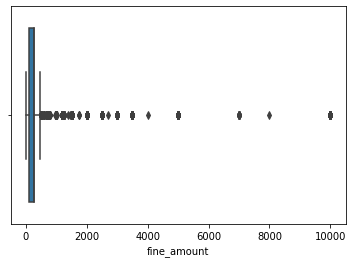

In [9]:
sns.boxplot(x = full.fine_amount)

In [10]:
# More than 90% of the observations are from state = "MI", so I will fill the NaNs
# using the mode as it is very representative of the population
state_mode = full.loc[:, "state"].mode().values[0]
full.loc[:, "state"] = full.loc[:, "state"].fillna(state_mode)

# fine_amount is (right-)skewed, so it makes more sense to use the median to fill the NaNs
fine_amount_median = full.loc[:, "fine_amount"].median()
full.loc[:, "fine_amount"] = full.loc[:, "fine_amount"].fillna(fine_amount_median)

In [11]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 311307 entries, 22056 to 369851
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   agency_name          311307 non-null  object 
 1   inspector_name       311307 non-null  object 
 2   state                311307 non-null  object 
 3   country              311307 non-null  object 
 4   violation_code       311307 non-null  object 
 5   disposition          311307 non-null  object 
 6   fine_amount          311307 non-null  float64
 7   admin_fee            311307 non-null  float64
 8   state_fee            311307 non-null  float64
 9   late_fee             311307 non-null  float64
 10  discount_amount      311307 non-null  float64
 11  clean_up_cost        311307 non-null  float64
 12  judgment_amount      311307 non-null  float64
 13  compliance           159880 non-null  float64
 14  hearing_month        311307 non-null  float64
 15  ticket_issued

In [12]:
full2 = full.loc[:, ["fine_amount", "state_fee", "state_fee", "late_fee", "discount_amount", "clean_up_cost", "judgment_amount", "compliance"]]

## Categorical variables

In [12]:
# Now let's get the categorical and numerical column names
categorical_variables = []

for column in full.columns:
    if full[column].dtype == "object":
        categorical_variables.append(column)

In [13]:
full = pd.get_dummies(full, prefix = categorical_variables, columns = categorical_variables)

In [14]:
full.shape

(311307, 576)

Now I'm all set to train the machine learning model

# Model selection and training

In [14]:
# First, I split back the full dataframe into train and test

# I add dropna to remove those rows where compliance is null, meaning that the subject
# wasn't responsible after all
train2 = full2.loc[train_ids, :].dropna()

# From test I remove compliance as I don't have the info for those rows
# In fact, it is what I'm trying to predict
test2 = full2.loc[test_ids, :].drop("compliance", axis = 1)

In [15]:
print(f"Train shape: {train2.shape}")
print(f"Test shape: {test2.shape}")

Train shape: (159880, 8)
Test shape: (61001, 7)


In [16]:
# Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

In [17]:
seed = 42
scaler = MinMaxScaler()

X = train2.drop("compliance", axis = 1)
X = scaler.fit_transform(X)
y = train2.compliance
print("Data succesfuly scaled")

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = seed)
print("Train-test split was succesful")

Data succesfuly scaled
Train-test split was succesful


In [18]:
#model = LogisticRegression(n_jobs = -1, random_state = seed)
model = RandomForestClassifier(n_jobs = -1)

model.fit(X_train, y_train)
print("Model training completed")

cm_predictions = model.predict(X_test)
cm = confusion_matrix(y_test, cm_predictions)

predictions = model.predict_proba(test2)
predictions = [prediction[1] for prediction in predictions]
print("Model predictions completed")
print("-" * 50)

train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f"Train score: {train_score}")
print(f"Test score: {test_score}")
print(cm)

Model training completed
Model predictions completed
--------------------------------------------------
Train score: 0.9356100408639814
Test score: 0.9348511383537653
[[37029    11]
 [ 2593   337]]


In [19]:
predictions = pd.Series(predictions, index = test_ids)
predictions.name = "compliance"
predictions.rename_axis("ticket_id", inplace = True)
predictions

ticket_id
284932    0.005259
285362    0.005259
285361    0.005259
285338    0.005259
285346    0.005259
            ...   
376496    0.005259
376497    0.005259
376499    0.005259
376500    0.005259
369851    0.238136
Name: compliance, Length: 61001, dtype: float64

<AxesSubplot:xlabel='compliance'>

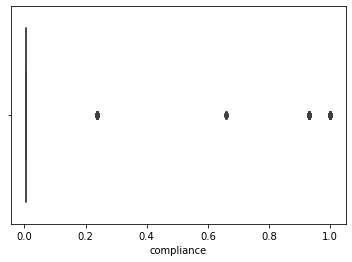

In [20]:
sns.boxplot(predictions)